In [1]:
# This notebook calculates the relationship between temperature and UHI during heatwaves
# import libraries
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.stats
import matplotlib
import cartopy.crs as ccrs

In [6]:
results_filename = 'US_results_HW.csv'
#results_filepath = 'plots/HWscatter/'
#results_filename = 'version1/USHWresults.csv'
results_filepath = 'plots/version1/HWscattercleaned/'
inputData = 'USghcnpairs_stationlengths.csv'

In [7]:
# functions

# plotting 
# define functions used for plotting 
def hw_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

# statistics
def pearsonr_autocorrelated(x, y):
    """
    Calculates a Pearson correlation coefficient and the p-value for testing
    non-correlation.
    The Pearson correlation coefficient measures the linear relationship
    between two datasets. Strictly speaking, Pearson's correlation requires
    that each dataset be normally distributed. Like other correlation
    coefficients, this one varies between -1 and +1 with 0 implying no
    correlation. Correlations of -1 or +1 imply an exact linear
    relationship. Positive correlations imply that as x increases, so does
    y. Negative correlations imply that as x increases, y decreases.
    The p-value roughly indicates the probability of an uncorrelated system
    producing datasets that have a Pearson correlation at least as extreme
    as the one computed from these datasets. The p-values are not entirely
    reliable but are probably reasonable for datasets larger than 500 or so.
    Parameters
    ----------
    x : (N,) array_like
        Input
    y : (N,) array_like
        Input
    Returns
    -------
    (Pearson's correlation coefficient,
     2-tailed p-value)
    References
    ----------
    http://www.statsoft.com/textbook/glosp.html#Pearson%20Correlation
    """
    # x and y should have same length.
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    r = np.corrcoef(y[1:],y[0:-1])[0,1] #y.autocorr(1)
    n_prime = n*(1-r)/(1+r)
    mx = x.mean()
    my = y.mean()
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym)
    r_den = np.sqrt(ss(xm) * ss(ym))
    r = r_num / r_den

    # Presumably, if abs(r) > 1, then it is only some small artifact of floating
    # point arithmetic.
    r = max(min(r, 1.0), -1.0)
    df = n_prime-2
    if abs(r) == 1.0:
        prob = 0.0
    else:
        t_squared = r*r * (df / ((1.0 - r) * (1.0 + r)))
        prob = betai(0.5*df, 0.5, df / (df + t_squared))
    return r, prob

def ss(a, axis=0):
    """
    Squares each element of the input array, and returns the sum(s) of that.
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int or None, optional
        The axis along which to calculate. If None, use whole array.
        Default is 0, i.e. along the first axis.
    Returns
    -------
    ss : ndarray
        The sum along the given axis for (a**2).
    See also
    --------
    square_of_sums : The square(s) of the sum(s) (the opposite of `ss`).
    Examples
    --------
    >>> from scipy import stats
    >>> a = np.array([1., 2., 5.])
    >>> stats.ss(a)
    30.0
    And calculating along an axis:
    >>> b = np.array([[1., 2., 5.], [2., 5., 6.]])
    >>> stats.ss(b, axis=1)
    array([ 30., 65.])
    """
    a, axis = _chk_asarray(a, axis)
    return np.sum(a*a, axis)

def _chk_asarray(a, axis):
    if axis is None:
        a = np.ravel(a)
        outaxis = 0
    else:
        a = np.asarray(a)
        outaxis = axis
    return a, outaxis

def betai(a, b, x):
    """
    Returns the incomplete beta function.
    I_x(a,b) = 1/B(a,b)*(Integral(0,x) of t^(a-1)(1-t)^(b-1) dt)
    where a,b>0 and B(a,b) = G(a)*G(b)/(G(a+b)) where G(a) is the gamma
    function of a.
    The standard broadcasting rules apply to a, b, and x.
    Parameters
    ----------
    a : array_like or float > 0
    b : array_like or float > 0
    x : array_like or float
        x will be clipped to be no greater than 1.0 .
    Returns
    -------
    betai : ndarray
        Incomplete beta function.
    """
    x = np.asarray(x)
    x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
    return scipy.special.betainc(a, b, x)


In [8]:
# Calculate the relationship between summertime  UHI and t_min, save it out for every city
pairs = pd.read_csv(inputData)
paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]

numhw = 150
finalhw = 50

# pre-allocate
slopes           = np.zeros(paired_df.shape[0])
residuals        = np.zeros(paired_df.shape[0])
correlations     = np.zeros(paired_df.shape[0])
urban_start_date = np.zeros(paired_df.shape[0])
urban_end_date   = np.zeros(paired_df.shape[0])
rural_start_date = np.zeros(paired_df.shape[0])
rural_end_date   = np.zeros(paired_df.shape[0])
n_events         = np.zeros(paired_df.shape[0])
mean_rural_temp  = np.zeros(paired_df.shape[0])
mean_UHI         = np.zeros(paired_df.shape[0])
p_value          = np.zeros(paired_df.shape[0])

In [9]:
for i in range(0, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['1985-01-01':].index, ruraldata['TMIN']['1985-01-01':].index).shape[0] > 900): 

        # Find the date at which they both start
        startdate = max(min(ruraldata['TMIN'].index), min(urbandata['TMIN'].index))

        # Calculate minimum daily thresholds starting from 1985
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 
        # clean data: eliminate min temperatures below 4 or above 35
        rural_tmin = rural_tmin[(rural_tmin>4) & (rural_tmin<35)]
        urban_tmin = urban_tmin[(urban_tmin>4) & (urban_tmin < 35)]
        #Get the hottest days based off tmin 
        hottestmin = rural_tmin.iloc[(-rural_tmin.values).argsort()[:numhw]] 
        minheatwaves = hottestmin

        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (minheatwaves.sort_index().index.to_timestamp().values[1:] - minheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        minheatwaves = minheatwaves.sort_index().iloc[np.where(time_diff > np.timedelta64(2, 'D'))]
        # Now the heatwaves are sorted in time order, but we want finalhw (50) of the most severe events. Save the hottest events
        minheatwaves = minheatwaves.sort_values(ascending=False).iloc[0:finalhw]

        rural_start_date[i] = rural_tmin[~np.isnan(rural_tmin)].index[0].year
        rural_end_date[i]   = rural_tmin[~np.isnan(rural_tmin)].index[-1].year
        urban_start_date[i] = urban_tmin[~np.isnan(urban_tmin)].index[0].year
        urban_end_date[i]   = urban_tmin[~np.isnan(urban_tmin)].index[-1].year

        #calculate UHI
        UHI = urban_tmin - rural_tmin#pd.to_numeric(urbandata['TMIN'].value/10.)[tmin.index] - tmin
        #UHImax = pd.to_numeric(urbandata['TMAX'].value/10.)[tmax.index] - tmax
        mean_UHI[i] = UHI.mean()
        
        x = rural_tmin[minheatwaves.index]#[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)] 
        y = UHI[minheatwaves.index]#[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
        ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
        
        if ind.sum() > 5: 
            mean_rural_temp[i] = x[ind].mean()

            plt.figure()
            handle = hw_scatter(x[ind],y[ind],'%s HW Temp vs UHI'%city, 'Rural Temp', 'UHI')
            plt.savefig(results_filepath + 'hwUHI%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
            plt.close()

            try: 
                V = np.polyfit(x[ind],y[ind],1, full = True)
                C = pearsonr_autocorrelated(x[ind], y[ind])
                slopes[i] = V[0][0]
                residuals[i] = V[1][0]
                correlations[i] = C[0]#np.corrcoef(x[ind],y[ind])[0,1]
                p_value[i]      = C[1]
                n_events[i] = ind.values.sum()

            except TypeError : 
                slopes[i] = np.nan
                residuals[i] = np.nan
                correlations[i] = np.nan
    else : 
        slopes[i] = np.nan
        residuals[i] = np.nan
        correlations[i] = np.nan
        
        
    if np.mod(i,10) == 0 : 
        
        results_df = pd.DataFrame()
        results_df['City']  = paired_df['City']
        results_df['Slope'] = slopes
        results_df['Residual'] = residuals
        results_df['Correlation'] = correlations
        results_df['P-value'] = p_value
        results_df['Urban start date'] = urban_start_date
        results_df['Urban end date'] = urban_end_date
        results_df['Rural start date'] = rural_start_date
        results_df['Rural end date'] = rural_end_date
        results_df['Data points'] = n_events
        results_df['Mean UHI'] = mean_UHI
        results_df['Mean JJA Rural Temp'] = mean_rural_temp

        results_df.to_csv(results_filename)
        
results_df = pd.DataFrame()
results_df['City']  = paired_df['City']
results_df['Slope'] = slopes
results_df['Residual'] = residuals
results_df['Correlation'] = correlations
results_df['P-value'] = p_value
results_df['Urban start date'] = urban_start_date
results_df['Urban end date'] = urban_end_date
results_df['Rural start date'] = rural_start_date
results_df['Rural end date'] = rural_end_date
results_df['Data points'] = n_events
results_df['Mean UHI'] = mean_UHI
results_df['Mean JJA Rural Temp'] = mean_rural_temp
results_df.to_csv(results_filename)

Mesa
Arlington
Irvine
New Haven
Fort Lauderdale


/Users/annascott2/git/ulmo-gottscott/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe[column_name][dates] = element_df[col][months]


Long Beach
Hartford
Providence
Birmingham
St. Petersburg
Virginia Beach
Oakland
West Palm Beach
Louisville
Charlotte
Columbus
San Bernardino
Bridgeport
St. Paul
Tucson
Fresno
Albuquerque
Kansas City
Tulsa
Ft. Worth
Austin
El Paso
Orlando
Jacksonville
Indianapolis
Richmond
Baltimore
San Jose
Sacramento
Las Vegas
Portland
Salt Lake City
Omaha
Oklahoma City
San Antonio
Raleigh
Cleveland
Cincinnati
Nashville
Memphis
Norfolk
Milwaukee
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Tampa
Philadelphia
Detroit
San Francisco
Denver
Houston
Miami
Atlanta
Chicago
Los Angeles
Washington, D.C.
New York


In [6]:
i

61

In [3]:
results_df = pd.read_csv('plots/version1/USHWresults_concatenated.csv')

In [54]:
results_df[results_df['City'].str.contains('Vegas')]

,Unnamed: 0,Unnamed: 0.1,City,Slope,Residual,Correlation,P-value,Urban start date,Urban end date,Rural start date,Rural end date,Data points,Mean UHI,Mean JJA Rural Temp
33,34,951,Las Vegas,0.394745,279.241882,0.091253,0.640451,1990.0,2016.0,2002.0,2015.0,39.0,6.091609,22.607692


In [5]:
#slopes = results_df['Slope']
correlations = results_df['Correlation']
pairs = pd.read_csv(inputData)
paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]

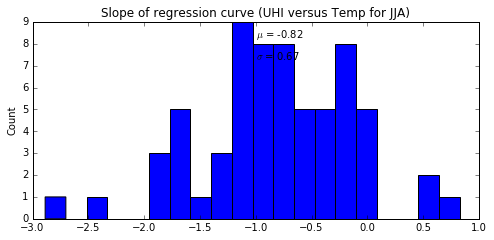

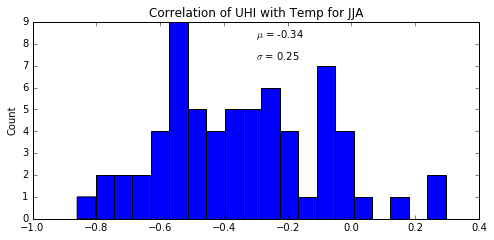

In [12]:
# plot slope histograme
data = slopes
data = data[~np.isnan(data)]
plt.figure(figsize=[8,12])
plt.subplot(3,1,1)
plt.hist(data, 20)
plt.title('Slope of regression curve (UHI versus Temp for JJA)')
#plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
plt.ylabel('Count')
plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.savefig(results_filepath + 'slopehistogram.png')

# plot correlation histogram
data = correlations
data = data[~np.isnan(data)]
plt.figure(figsize=[8,12])
plt.subplot(3,1,2)
plt.hist(data, 20)
plt.title('Correlation of UHI with Temp for JJA')
#plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
plt.ylabel('Count')
plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.savefig(results_filepath + '/correlationhistogram.png')

# # make a map of the slopes
# fig = plt.figure(figsize=[15,15])
# # Define colors 
# cmap = matplotlib.cm.coolwarm
# c = slopes
# bounds = np.linspace(-1,1,11)
# norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# marker_size = 75
# # Define the cartopy basemaps
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# ind = np.isnan(c)
# plotHandle = ax.scatter(paired_df['Urban Lon'], paired_df['Urban Lat'],#x,y,
#                         c = c[ind], s = marker_size, transform=ccrs.Geodetic(),
#                  cmap = cmap,
#                  norm = norm)
# # mask insignificantly correlated cities with a white circle
# insig_inds = np.where(results_df['P-value']>0.05)

# ax.scatter(paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
#         c = 'none', s = marker_size, transform=ccrs.Geodetic(), edgecolors='white',)

# #cbar1 = plt.colorbar(plotHandle, label = 'Slope', orientation='horizontal')
# plt.title('Slope of UHI vs. Temp')
# plt.savefig(results_filepath + 'slopemap.png')

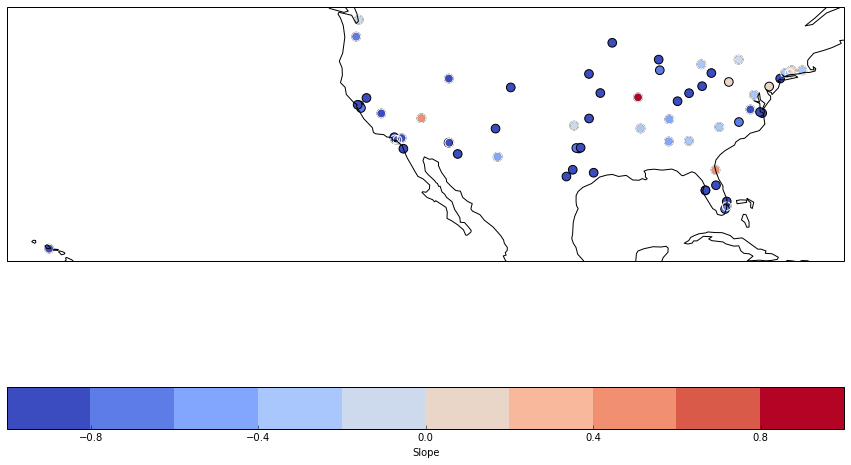

In [11]:
results_df = results_df.set_index(results_df.City)

fig = plt.figure(figsize=[15,15])
# Define colors 
cmap = matplotlib.cm.coolwarm
c = results_df[~np.isnan(results_df['Slope'])].Slope#slopes
#ind = np.where(~np.isnan(c)) 
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 75
# Define the cartopy basemaps
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, transform=ccrs.Geodetic(),
                 cmap = cmap,
                 norm = norm)

# mask insignificantly correlated cities with a white circle
#insig_inds = np.where(results_df['P-value']>0.05)
c_insignificant = results_df[results_df['P-value']>0.05]
ax.scatter(paired_df.set_index('City').loc[c_insignificant.index]['Urban Lon'], paired_df.set_index('City').loc[c_insignificant.index]['Urban Lat'], 
    #paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
        c = 'none', s = marker_size, transform=ccrs.Geodetic(), edgecolors='white',)

cbar1 = plt.colorbar(plotHandle, label = 'Slope', orientation='horizontal')
plt.savefig(results_filepath + 'slopemap.png')

In [91]:
c_insignificant = results_df[results_df['P-value']>0.05]

In [92]:
c_insignificant.index

Index([u'Mesa', u'New Haven', u'Fort Lauderdale', u'Hartford', u'Providence',
       u'Birmingham', u'Louisville', u'Charlotte', u'San Bernardino',
       u'Bridgeport', u'Ft. Worth', u'El Paso', u'Sacramento', u'Las Vegas',
       u'Salt Lake City', u'Oklahoma City', u'Memphis', u'Buffalo',
       u'Honolulu', u'Seattle', u'St. Louis', u'Detroit', u'Atlanta',
       u'Washington, D.C.'],
      dtype='object', name=u'City')

In [87]:
paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'],

(City
 Mesa               -111.921
 Arlington           -97.073
 Irvine             -117.866
 New Haven           -72.903
 Fort Lauderdale     -80.106
 Long Beach         -118.146
 Hartford            -72.650
 Providence          -71.432
 Birmingham          -86.745
 St. Petersburg      -82.540
 Virginia Beach      -76.033
 Oakland            -122.220
 West Palm Beach     -80.099
 Louisville          -85.739
 Charlotte           -80.955
 Columbus            -82.920
 San Bernardino     -117.388
 Bridgeport          -73.416
 Tucson             -110.955
 Fresno             -119.719
 Kansas City         -94.596
 Tulsa               -95.887
 Ft. Worth           -97.350
 Austin              -97.760
 El Paso            -106.375
 Orlando             -81.333
 Jacksonville        -81.392
 Richmond            -77.392
 San Jose           -122.048
 Sacramento         -121.416
                      ...   
 Oklahoma City       -97.600
 San Antonio         -98.483
 Raleigh             -78.698
 Clevela

In [66]:
results_df = results_df.set_index(results_df.City)
ind = np.where(~np.isnan(results_df['Slope'])) 
results_df.iloc[ind].shape

(64, 14)

In [76]:
results_df[~np.isnan(results_df['Slope'])]

,Unnamed: 0,Unnamed: 0.1,City,Slope,Residual,Correlation,P-value,Urban start date,Urban end date,Rural start date,Rural end date,Data points,Mean UHI,Mean JJA Rural Temp
City,,,,,,,,,,,,,,
Mesa,0,917,Mesa,-0.632372,248.051050,-0.222056,1.220275e-01,1985.0,2016.0,1985.0,2016.0,46.0,2.395792,28.513043
Arlington,1,918,Arlington,-3.198411,240.496036,-0.593766,1.307596e-02,1991.0,2016.0,2000.0,2016.0,35.0,0.500997,26.462857
Irvine,2,919,Irvine,-0.997274,263.663224,-0.677867,5.069258e-11,1985.0,2016.0,2001.0,2015.0,49.0,4.548514,17.771429
New Haven,3,920,New Haven,-0.096482,397.012527,-0.022184,9.099313e-01,1985.0,2016.0,2008.0,2016.0,30.0,-0.687173,22.073333
Fort Lauderdale,4,921,Fort Lauderdale,-0.580262,107.285992,-0.190715,2.038761e-01,1998.0,2016.0,2002.0,2016.0,49.0,3.755201,24.416327
Long Beach,5,922,Long Beach,-0.372786,224.705395,-0.245333,3.631900e-02,1985.0,2016.0,2000.0,2016.0,50.0,0.731981,25.018000
Hartford,6,923,Hartford,0.035999,301.197054,0.019340,8.800207e-01,1985.0,2016.0,1986.0,1990.0,41.0,3.629875,16.907317
Providence,7,924,Providence,-0.124869,56.311640,-0.066821,6.690968e-01,1985.0,2016.0,1985.0,2016.0,50.0,1.898457,21.538000
Birmingham,8,925,Birmingham,-0.418948,197.392256,-0.225062,1.791911e-01,1985.0,2016.0,1985.0,2016.0,50.0,0.697838,24.830000


In [77]:
c = results_df[~np.isnan(results_df['Slope'])].Slope#slopes

In [78]:
c.index

Index([u'Mesa', u'Arlington', u'Irvine', u'New Haven', u'Fort Lauderdale',
       u'Long Beach', u'Hartford', u'Providence', u'Birmingham',
       u'St. Petersburg', u'Virginia Beach', u'Oakland', u'West Palm Beach',
       u'Louisville', u'Charlotte', u'Columbus', u'San Bernardino',
       u'Bridgeport', u'Tucson', u'Fresno', u'Kansas City', u'Tulsa',
       u'Ft. Worth', u'Austin', u'El Paso', u'Orlando', u'Jacksonville',
       u'Richmond', u'San Jose', u'Sacramento', u'Las Vegas', u'Portland',
       u'Salt Lake City', u'Omaha', u'Oklahoma City', u'San Antonio',
       u'Raleigh', u'Cleveland', u'Cincinnati', u'Nashville', u'Memphis',
       u'Norfolk', u'Milwaukee', u'Buffalo', u'Pittsburgh', u'Minneapolis',
       u'Honolulu', u'Seattle', u'Phoenix', u'San Diego', u'St. Louis',
       u'Dallas', u'Tampa', u'Philadelphia', u'Detroit', u'San Francisco',
       u'Denver', u'Houston', u'Miami', u'Atlanta', u'Chicago', u'Los Angeles',
       u'Washington, D.C.', u'New York'],
      dt

In [ ]:
paired_df['Urban Lon'].iloc[ind].values, paired_df['Urban Lat'].iloc[ind].values

In [85]:
paired_df.set_index('City').loc[c.index]

,Unnamed: 0,Urban station,Urban Lat,Urban Lon,Urban brightness,Rural station,Rural Lat,Rural Lon,Rural brightness
City,,,,,,,,,
Mesa,917,USC00028499,33.425,-111.921,63.0,USC00028214,33.557,-111.535,7.0
Arlington,918,USC00410337,32.757,-97.073,63.0,USR0000TLBJ,33.172,-97.375,8.0
Irvine,919,USC00047888,33.744,-117.866,63.0,USC00047836,33.531,-117.552,11.0
New Haven,920,USC00065077,41.407,-72.903,60.0,USC00060808,41.120,-73.080,7.0
Fort Lauderdale,921,USC00083168,26.140,-80.106,63.0,USC00088368,26.470,-80.640,4.0
Long Beach,922,USW00023129,33.811,-118.146,63.0,USW00023191,33.405,-118.415,4.0
Hartford,923,USW00014752,41.736,-72.650,62.0,USC00193167,42.066,-72.900,8.0
Providence,924,USW00014765,41.721,-71.432,62.0,USC00375270,41.856,-71.733,12.0
Birmingham,925,USW00013876,33.565,-86.745,63.0,USC00010505,33.452,-87.357,7.0


In [40]:
paired_df['Urban Lon'].iloc[ind].values

array([-111.921,  -97.073, -117.866,  -72.903,  -80.106, -118.146,
        -72.65 ,  -71.432,  -86.745,  -82.54 ,  -76.033, -122.22 ,
        -80.099,  -85.739,  -80.955,  -82.92 , -117.388,  -73.416,
       -110.955, -119.719, -106.615,  -94.596,  -95.887,  -97.35 ,
        -97.76 , -106.375,  -81.333,  -86.28 ,  -76.683, -122.048,
       -121.416, -115.116, -122.6  , -111.969,  -95.899,  -97.6  ,
        -98.483,  -78.698,  -81.86 ,  -84.418,  -86.689,  -89.986,
        -76.283,  -87.904,  -78.736,  -79.859,  -93.228, -157.816,
       -122.3  , -112.003, -117.183,  -90.13 ,  -96.855,  -82.54 ,
        -75.231,  -83.01 , -122.426, -104.869,  -95.36 ,  -80.285,
        -84.441,  -87.777, -118.235,  -76.97 ])

In [41]:
paired_df['Urban Lat'].iloc[ind].values

array([ 33.425,  32.757,  33.744,  41.407,  26.14 ,  33.811,  41.736,
        41.721,  33.565,  27.961,  36.816,  37.721,  26.684,  38.181,
        35.223,  39.904,  33.951,  41.4  ,  32.131,  36.78 ,  35.041,
        39.12 ,  36.199,  32.816,  30.32 ,  31.811,  28.545,  39.707,
        39.166,  37.405,  38.555,  36.234,  45.59 ,  40.778,  41.31 ,
        35.388,  29.544,  35.794,  41.413,  39.103,  36.118,  35.056,
        36.95 ,  42.955,  42.948,  40.391,  44.883,  21.271,  47.53 ,
        33.427,  32.733,  29.916,  32.851,  27.961,  39.868,  42.409,
        37.77 ,  39.763,  29.98 ,  25.817,  33.63 ,  41.737,  34.051,
        38.913])

In [45]:
ind = np.where(~np.isnan(c)) 
c.iloc[ind]

0    -0.632372
1    -3.198411
2    -0.997274
3    -0.096482
4    -0.580262
5    -0.372786
6     0.035999
7    -0.124869
8    -0.418948
9    -1.217737
10   -1.051088
11   -1.219730
12   -1.090123
13   -0.850870
14   -0.267002
15   -1.031524
16   -1.106331
17   -0.382376
19   -1.770196
20   -1.280202
21   -1.435532
22   -1.198283
23   -0.675841
24   -1.104766
25   -0.430271
26   -1.479369
27    0.456749
29   -1.487305
31   -0.829088
32   -1.479216
        ...   
37   -0.151174
38   -1.458987
39   -0.735383
40   -0.851207
41   -1.616834
42   -0.667855
43   -0.434487
44   -0.889142
45   -1.091572
46   -0.123590
47    0.000000
48   -1.028631
49   -0.889578
50    0.039551
51   -1.696055
52   -1.225879
53    0.778788
55   -2.438476
56   -1.217737
57    0.000000
58   -0.352584
59   -1.144741
60   -0.934090
61   -1.981506
62   -0.742292
63    0.263897
64   -0.846281
65   -1.347478
66   -0.147843
67   -1.748064
Name: Slope, dtype: float64

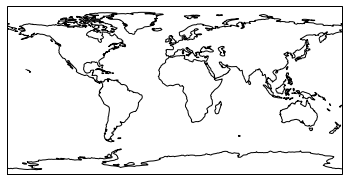

In [10]:
# Define colors 
cmap = matplotlib.cm.coolwarm
c = slopes
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 75
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ind = np.isnan(c)

In [12]:
plotHandle = ax.scatter(paired_df['Urban Lon'], paired_df['Urban Lat'],#x,y,
                        c = c, s = marker_size, transform=ccrs.Geodetic(),
                 cmap = cmap,
                 norm = norm
                       )

ValueError: to_rgba: Invalid rgba arg "-0.632372020109"
to_rgb: Invalid rgb arg "-0.632372020109"
cannot convert argument to rgb sequence

In [10]:
results_df

,City,Slope,Residual,Correlation,P-value,Urban start date,Urban end date,Rural start date,Rural end date,Data points,Mean UHI,Mean JJA Rural Temp
117,Ciudad Juárez,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
119,Mexicali,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
124,Tijuana,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
170,Mesa,0.000000,0.000000,0.000000,0.000000e+00,1985.0,1988.0,1985.0,2016.0,0.0,4.026797,0.000000
172,Irvine,NaN,NaN,NaN,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
173,New Haven,NaN,NaN,NaN,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
175,Hartford,0.035999,301.197054,0.019340,8.800207e-01,1985.0,2016.0,1986.0,1990.0,41.0,3.629875,16.907317
176,Providence,-0.124869,56.311640,-0.066821,6.690968e-01,1985.0,2016.0,1985.0,2016.0,50.0,1.898457,21.538000
177,Birmingham,NaN,NaN,NaN,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
178,St. Petersburg,-1.941629,335.313648,-0.592747,1.403576e-03,1985.0,2016.0,1985.0,2014.0,50.0,1.506546,26.062000


In [9]:
results0 = pd.read_csv('plots/version1/USHWresults.csv')
#results1 = pd.read_csv('plots/version1/USHWresults3-22.csv')
#results2 = pd.read_csv('plots/version1/USHWresults.csv')

In [12]:
results2.iloc[0:3] = results0.iloc[0:3]
results2.iloc[3:22] = results1.iloc[3:22]


In [18]:
results_df = results2.drop(21)

In [39]:
results_df.to_csv('plots/version1/USHWresults_concatenated.csv')